In [182]:
%pylab inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv
import pandas as pd
# Numpy lets us work with arrays
import numpy as np
# Sklearn provides various modules with a common API
from sklearn import svm, tree, neighbors, neural_network, linear_model, ensemble
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ShuffleSplit

# import pickle
import pickle

# other models
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# turn off warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['fmin']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [145]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('train.csv').set_index("PassengerId")
test_data = pd.read_csv('test.csv').set_index("PassengerId")

In [39]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_data.columns[train_data.isna().any()].tolist()

['Age', 'Cabin', 'Embarked']

In [146]:
def parse_title(df):
    # title
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')
    return df

def process_name(df):
    # parse title first
    df = parse_title(df)
    df['LastName'] = df.Name.str.split(',').str[0]
    # get information about sex from title
    df['IsWomanOrBoy'] = ((df.Title == 'Master') | (df.Sex == 'female'))
    return df

def add_family_info(df):
    family = df.groupby(df.LastName).Survived
    # count woman or boy
    df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
    # df['WomanOrBoyCount'] = df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount - 1, axis=0)
    df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
    # df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0)
    df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
    df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
    df['Alone'] = (df.WomanOrBoyCount == 0)

    # Family_Size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['Single'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallF'] = df['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    df['MedF'] = df['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    df['LargeF'] = df['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
    df.drop(columns = ['FamilySize'], inplace=True)
    return df

def fill_missing(df):
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    # Cabin, Deck
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'
    # propogate median fair
    med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
    df['Fare'] = df['Fare'].fillna(med_fare)
    #Age
    df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))
    # family info
    df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
    df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
    df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
    df.Alone = df.Alone.fillna(0)
    return df    

In [134]:
def encode_types(df):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    categorical_columns = []
    features = df.columns.values.tolist()
    for col in features:
        if df[col].dtype in numerics: continue
        categorical_columns.append(col)
    # Encoding categorical features
    for col in categorical_columns:
        if col in df.columns:
            le = LabelEncoder()
            le.fit(list(df[col].astype(str).values))
            df[col] = le.transform(list(df[col].astype(str).values))
    return df
    

In [147]:
RANDOM_SEED = 10

# combine train and test into single df for preprocessing --> becareful bc test won't have survived column
df = pd.concat([train_data, test_data], axis=0, sort=False)
df.head()

df = process_name(df)

df = add_family_info(df)

# fill in missing
df = fill_missing(df)

# drop these columns
cols_to_drop = ['Name','Ticket','Cabin']
df = df.drop(cols_to_drop, axis=1)

# encode the string datatypes using LabelEncoder
df = encode_types(df)

# separate into data and survived label
train_data, test_data = df.loc[train_data.index], df.loc[test_data.index]
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

test_data = test_data.loc[:, test_data.columns != 'Survived']
print(test_data.head())

# try kfold from scikit-learn
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_SEED)

# print(X_train.head())
# print(y_train.head())
# print(test_data.head())

             Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Title  \
PassengerId                                                              
892               3    1  34.5      0      0   7.8292         1     10   
893               3    0  47.0      1      0   7.0000         2     11   
894               2    1  62.0      0      0   9.6875         1     10   
895               3    1  27.0      0      0   8.6625         2     10   
896               3    0  22.0      1      1  12.2875         2     11   

             LastName  IsWomanOrBoy  WomanOrBoyCount  FamilySurvivedCount  \
PassengerId                                                                 
892               401             0                3                  3.0   
893               846             1                1                  0.0   
894               552             0                0                  0.0   
895               854             0                0                  0.0   
896               3

In [148]:
train_data.columns[train_data.isna().any()].tolist()
train_data[train_data['Embarked'].isna() == True]
#train_data['Embarked']
#test_data.columns[test_data.isna().any()].tolist()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LastName,IsWomanOrBoy,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Single,SmallF,MedF,LargeF,Deck
PassengerId,,,,,,,,,,,,,,,,,,,,


## Keeping track of models

For now we will keep a dictionary with all the models performance

Model will map to (fnr, fpr)

Next we will pickle them so we don't have to waste time retraining

In [188]:
'''
Use this method to score the cross evaluation
This way we will have the confusion matrix values for each fold and we can easily get the average fnr and fpr
'''
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    accuracy = clf.score(X, y)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1], "acc": accuracy}

# fit and evaluate model
def eval(model):
    # cross validation --> generate different train test splits
    
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=RANDOM_SEED)

    model.fit(X_train.values, y_train.values)

    # cross eval accuracy
    score = cross_validate(model, X_train.values, y_train.values, cv = cv, scoring=confusion_matrix_scorer)
    print(score)

    tn = np.mean(score['test_tn'])
    fp = np.mean(score['test_fp'])
    fn = np.mean(score['test_fn'])
    tp = np.mean(score['test_tp'])
    acc = np.mean(score['test_acc'])

    print("Accuracy", acc)
    print("")
    print("True Negatives", tn)
    print("False Positives", fp)
    print("False Negatives", fn)
    print("True Positives", tp)
    print("")
    fpr = fp / (fp + tn)
    print("FPR", fpr)
    fnr = fn / (fn + tp)
    print("FNR", fnr)
    models[type(model).__name__] = (fpr, fnr)

In [150]:
models = {}

## Tree

In [169]:
tree_clf = tree.DecisionTreeClassifier()
eval(tree_clf)

Accuracy 0.826865671641791

True Negatives 140.8
False Positives 26.8
False Negatives 19.6
True Positives 80.8

FPR 0.15990453460620524
FNR 0.1952191235059761


## KNN

In [152]:
knn_clf = neighbors.KNeighborsClassifier()
eval(knn_clf)

Accuracy 0.6694029850746268

True Negatives 139.8
False Positives 27.8
False Negatives 60.8
True Positives 39.6

FPR 0.16587112171837706
FNR 0.6055776892430278


## NN

In [153]:
NN_clf = neural_network.MLPClassifier()
eval(NN_clf)

Accuracy 0.8723880597014926

True Negatives 160.2
False Positives 7.4
False Negatives 26.8
True Positives 73.6

FPR 0.0441527446300716
FNR 0.2669322709163347


## SVM

In [154]:
svm_clf = svm.SVC(kernel='linear')
eval(svm_clf)

Accuracy 0.9

True Negatives 165.8
False Positives 1.8
False Negatives 25.0
True Positives 75.4

FPR 0.010739856801909307
FNR 0.249003984063745


In [155]:
svm_linear = svm.LinearSVC()
eval(svm_linear)

Accuracy 0.7194029850746269

True Negatives 124.8
False Positives 42.8
False Negatives 32.4
True Positives 68.0

FPR 0.2553699284009546
FNR 0.32270916334661354


/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

## Linear

In [156]:
logistic = linear_model.LogisticRegression()
eval(logistic)

Accuracy 0.8708955223880597

True Negatives 156.8
False Positives 10.8
False Negatives 23.8
True Positives 76.6

FPR 0.06443914081145584
FNR 0.2370517928286853


/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

In [157]:
perceptron = linear_model.Perceptron()
eval(perceptron)

Accuracy 0.6201492537313433

True Negatives 136.6
False Positives 31.0
False Negatives 70.8
True Positives 29.6

FPR 0.18496420047732698
FNR 0.7051792828685258


In [158]:
ridge = linear_model.RidgeClassifier()
eval(ridge)

Accuracy 0.894776119402985

True Negatives 162.4
False Positives 5.2
False Negatives 23.0
True Positives 77.4

FPR 0.03102625298329356
FNR 0.2290836653386454


In [159]:
sdg = linear_model.SGDClassifier()
eval(sdg)

Accuracy 0.6559701492537314

True Negatives 143.8
False Positives 23.8
False Negatives 68.4
True Positives 32.0

FPR 0.14200477326968972
FNR 0.6812749003984064


## Ensemble

In [160]:
random_forest = ensemble.RandomForestClassifier()
eval(random_forest)

Accuracy 0.894776119402985

True Negatives 161.6
False Positives 6.0
False Negatives 22.2
True Positives 78.2

FPR 0.03579952267303103
FNR 0.22111553784860555


In [161]:
gradient_boost = ensemble.GradientBoostingClassifier()
eval(gradient_boost)

Accuracy 0.8947761194029852

True Negatives 161.2
False Positives 6.4
False Negatives 21.8
True Positives 78.6

FPR 0.03818615751789976
FNR 0.2171314741035857


In [162]:
extra_trees = ensemble.ExtraTreesClassifier()
eval(extra_trees)

Accuracy 0.8843283582089552

True Negatives 159.0
False Positives 8.6
False Negatives 22.4
True Positives 78.0

FPR 0.0513126491646778
FNR 0.2231075697211155


In [163]:
bagging = ensemble.BaggingClassifier()
eval(bagging)

Accuracy 0.8895522388059701

True Negatives 159.0
False Positives 8.6
False Negatives 21.0
True Positives 79.4

FPR 0.0513126491646778
FNR 0.2091633466135458


## Random Forest

In [177]:
random_forest = GridSearchCV(estimator=ensemble.RandomForestClassifier(), param_grid={'n_estimators': [200, 300, 400, 500]}, cv=10).fit(X_train, y_train)
random_forest.fit(X_train, y_train)
acc = random_forest.score(X_train, y_train)
# find best paremeters
# print(acc,random_forest.best_params_)

random_forest = ensemble.RandomForestClassifier(n_estimators = 500)
eval(random_forest)

Accuracy 0.8947761194029852

True Negatives 161.8
False Positives 5.8
False Negatives 22.4
True Positives 78.0

FPR 0.034606205250596656
FNR 0.2231075697211155


## XGB

In [191]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 

space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(5, 8, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }

# best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)

# params = space_eval(space_xgb, best)

xgb_clf = XGBClassifier()
# xgb_clf.fit(X_train, y_train)
# acc = xgb_clf.score(X_train, y_train)
# print("Accuracy", acc)
eval(xgb_clf)

/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:44:05] WARNING: /Users/runner/miniforge3/cond

/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/tristanpeat/miniforge3/envs/tensorflow/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [170]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_matrix(model):
    y_pred = model.cross_validate_predict(X)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_truth, y_pred)
    class_names=['0', '1']
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix, without normalization')

    plt.show()

#  show_matrix(knn_clf)

In [195]:
def create_pred_csv(model):
    predictions = model.predict(test_data.values)
    pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
    type(pred_df)
    pred_df.to_csv(type(model).__name__ + 'predictions.csv', header=True, sep=',')


# think the test_data has NaN so it really doesn't like it
create_pred_csv(gradient_boost)

TypeError: only size-1 arrays can be converted to Python scalars

## Function to display pareto front

We will give it the model dict and all the fpr and fnr that we have

https://oapackage.readthedocs.io/en/latest/examples/example_pareto.html

https://stackoverflow.com/questions/21294829/fast-calculations-of-the-pareto-front-in-r

The trick here is to sort by x, which then allows you to limit your check to making sure that all prior values of x must have greater values of y to ensure that point is on the frontier.

In [192]:
def create_models_df(models):
    df = pd.DataFrame(columns = ['model', 'fpr', 'fnr'])
    for model in models:
        fpr, fnr = models[model]
        df.loc[len(df.index)] = [model, fpr, fnr]
    return df

def find_hof(df):
    out = {}
    for index, row in df.iterrows():
        # look at all the models with a higher fpr
        tmp = df[df.fpr < row['fpr']]
        # drop the ones with a higher fnr
        tmp = tmp[tmp.fnr <= row['fnr']]
        # not optimal
        if len(tmp)  == 0:
            model = row['model']
            fpr = row['fpr']
            fnr = row['fnr']
            out[model] = (fpr, fnr)
    return out


df = create_models_df(models)
hof = find_hof(df)
print(hof)


{'DecisionTreeClassifier': (0.15990453460620524, 0.1952191235059761), 'SVC': (0.010739856801909307, 0.249003984063745), 'RidgeClassifier': (0.03102625298329356, 0.2290836653386454), 'RandomForestClassifier': (0.034606205250596656, 0.2231075697211155), 'GradientBoostingClassifier': (0.03818615751789976, 0.2171314741035857), 'BaggingClassifier': (0.0513126491646778, 0.2091633466135458)}


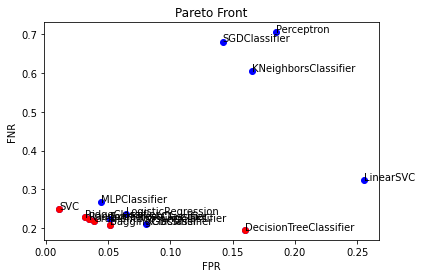

In [193]:
def pareto_frontier(models, hof):
    for model in models:
        fpr, fnr = models[model]
        plt.scatter(fpr, fnr, color='b')
        if model in hof:
            best_fpr, best_fnr = hof[model]
            plt.scatter(best_fpr, best_fnr, color='r')
            plt.plot(best_fpr, best_fnr, color='r', drawstyle='steps-post')

        plt.annotate(str(model), (fpr, fnr))
    plt.xlabel("FPR")
    plt.ylabel("FNR")
    plt.title("Pareto Front")
    plt.show()
pareto_frontier(models, hof)